# Laboratorio 4

**Nombre:** Luis Angel Tórtola  
**Carnet:** 25007713

---


Dos cientificos proponen utilizar "plantillas" como parte de un sistema para detectar "playeras" de imágenes. Las plantillas buscan describir partes comunes de la "playeras" como las mangas, el cuerpo y el cuello, además de descartar otras como las piernas y la cabeza.

La estrategia consiste en:
   1. detectar la presencia o no de las partes en la imágen.

   2. Utilizar vectores que le dan importancia a la presencia de cada uno de las partes para calcular un "score" que significa que tan probable es que la imagen represente una "playera". Por ejemplo:
   $$ 0.95\, \text{cuerpo} + 0.87 \, \text{mangas} + 0.4\, \text{cuello} - 2.3 \, \text{piernas} - 1.8 \, \text{cabeza}$$
   
   El razonamiento es que si una imagen es una playera debe tener un cuerpo, mangas y probablemente un cuello, pero si tiene piernas y la cabeza es menos probable que lo sea.

# Imágenes de Prueba

Para probar las "ideas" de los cientificos utilizara un conjunto de imágenes de prueba y los features prefabricados. Estos se encuentran guardados en el archivo "labp_data.npz".  Puede usar el código siguiente para cargar los tensores del archivo. 

También se incluye una vizualización de los ejemplos y las "platillas".

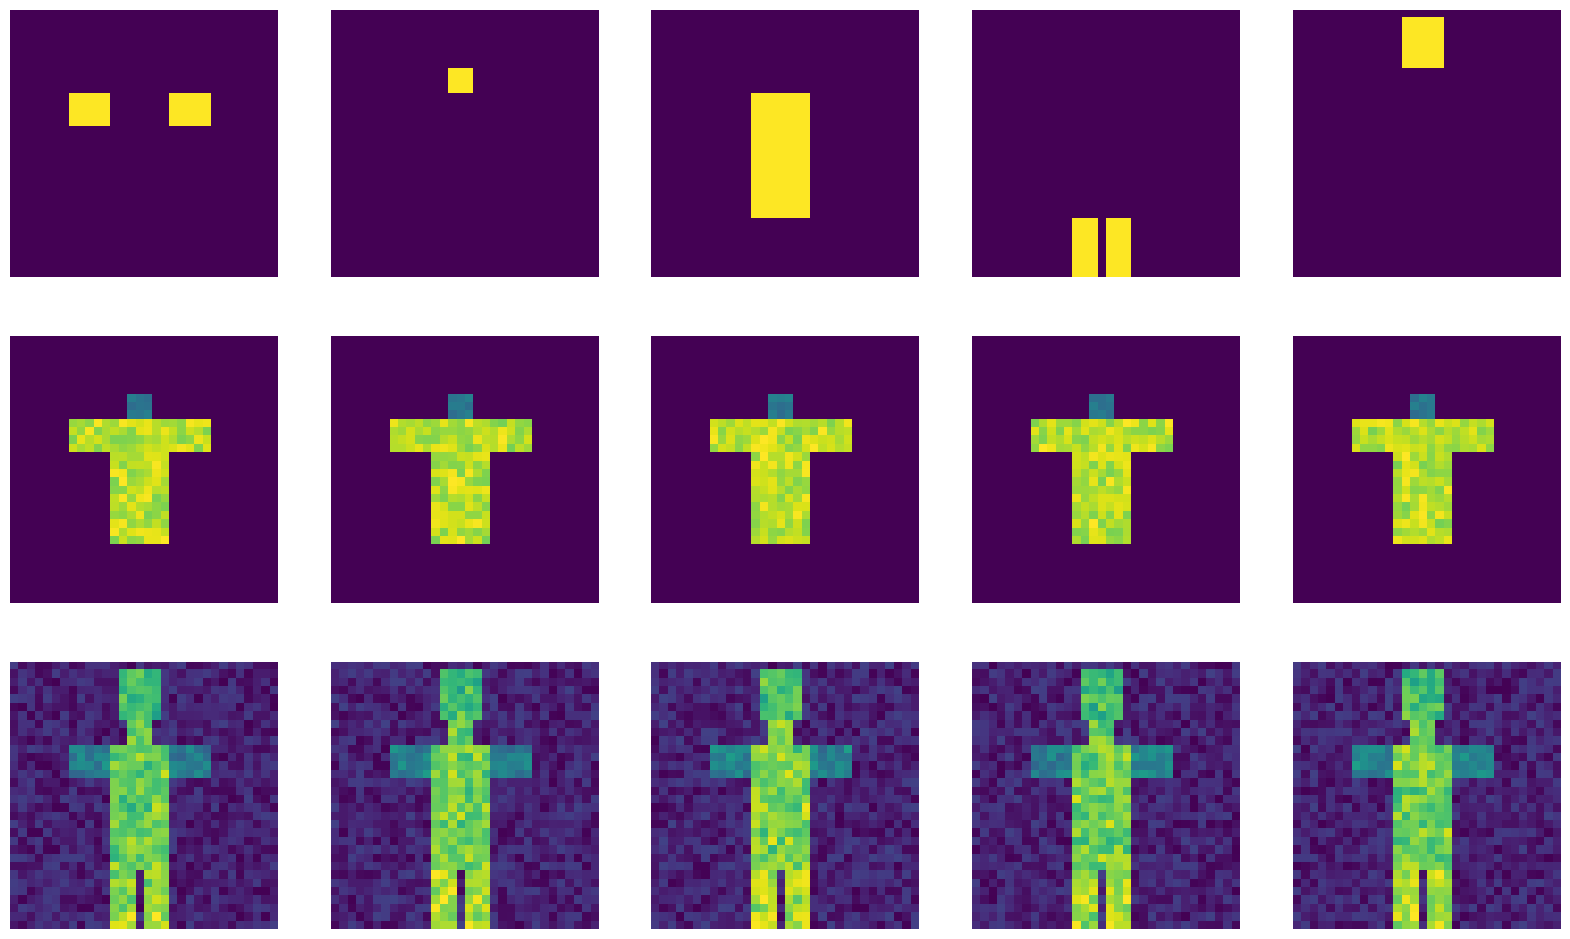

In [1]:
"""
   Recuerde copiar el archivo labp_data.npz
   a su carpeta de trabajo para poder cargar los archivos.
"""

import numpy as np
import matplotlib.pyplot as plt

# Abriendo archivo npzmangas = np.zeros((32, 32), dtype=float)
data = np.load('labp_data.npz')

playeras = data['playeras']
no_playeras = data['no_playeras']
plantillas = data['features']

fig, ax = plt.subplots(3, 5, figsize = (20, 12))

playeras_idxs = np.random.choice(100, 5)
no_playeras_idxs = np.random.choice(100, 5)

for j in range(5):
    ax[0, j].imshow(plantillas[j,:,:])
    ax[1, j].imshow(playeras[playeras_idxs[j], :, :])
    ax[2, j].imshow(no_playeras[no_playeras_idxs[j], :, :])
    ax[0, j].axis('off')
    ax[1, j].axis('off')
    ax[2, j].axis('off')

## Idea 1

La primera idea consiste en usar cada una de los features y medir la proyección sobre cada uno de ellos usando:
$$ p_{ij} = \sum_{k=0}^{31} \sum_{l=0}^{31} \text{imgs}_{ikl} \, \text{feat}_{jkl} = \text{imgs}_{i} \cdot \text{feat}_j$$

Para esto debe **normalizar** los vectores o imagenes de las plantillas.

Note que $p_{ij}$ es solo el producto punto, pero realizado entre dos matrices.

Como habrá notado las plantillas corresponden a partes:

{0: mangas, 1: cuello, 2: cuerpo, 3: piernas, 4: cabeza}

De forma que la presencia de cada una de ellas tiene un peso para determinar si el objeto es una playera o no. La propuesta del cientifico uno es darles los siguientes valores:

- $\alpha_0 = 0.9$ importancia de que aparezcan mangas
- $\alpha_1 = 0.5$ importancia de que aparezcan el cuello
- $\alpha_2 = 1.5$ importancia de que aparezcan el cuerpo
- $\alpha_3 = -2.1$ penalización por que aparezcan piernas
- $\alpha_4 = -1.5$ penalización por que aparezca la cabeza

El "score" o calificación que se usara para determinar si una imágen es una playera o no es calculada como:
$$ s_{i} = \sum_{j=0}^4 \alpha_i \, p_{ij} $$

## Tarea 1

Construya una función, utilice la firma proporcionada abajo, para calcular el "score" de cada imágen en un tensor $(N, 32, 32)$ donde $N$ es el número de imágenes.

- Pruebe su función sobre el tensor playeras.
- Pruebe su función sobre el tensor no_playeras.

## Notas

- Recuerde utilizar las operaciones entre Numpy.
- Procure no utilizar los loop for, while, etc donde sea posible.
- Tome en cuenta que para hacer compatibles operaciones entre arreglos de Numpy puede utilizar la función reshape e.g. T.reshape(5, 1, 32, 32) o T.reshape(5, 1, 32
- En este caso particular es plausible usar directamente las proyecciónes ya que los vectores son ortogonales, en otro caso sería necesario tomar en cuenta las relaciones entre las plantillas.
- Para la norma puede utilizar np.linalg.norm(tensor, axis=(2, 3))

In [2]:
def is_playera(imgs_tensor, weights, features):
    
    norm_features = features / np.linalg.norm(features, axis=(1, 2))[:, None, None]
    projections = np.tensordot(imgs_tensor, norm_features, axes=([1, 2], [1, 2]))
    scores = np.dot(projections, weights)

    return scores
    # return np.zeros(imgs_tensor.shape[0])

# modifique el vector para cumplir con los requisitos de la tarea
weights = np.array([0.9, 0.5, 1.5, -2.1, -1.5])

playeras_score = is_playera(playeras, weights, plantillas)

print(f"Promedio de score para playeras: {np.average(playeras_score)}")
print(f"Desviación estandar de las playeras: {np.std(playeras_score)}")

no_playeras_score = is_playera(no_playeras, weights, plantillas)

print(f"Promedio de score para NO playeras: {np.average(no_playeras_score)}")
print(f"Desviación estandar de las NO playeras: {np.std(no_playeras_score)}")


Promedio de score para playeras: 1.776405229193828
Desviación estandar de las playeras: 0.0011443422376811042
Promedio de score para NO playeras: -0.15552111488188428
Desviación estandar de las NO playeras: 0.017931434821114665


## Idea 2

La segunda idea se similar que la anterior excepto que en lugar de las proyecciones se desea utilizar la distancia coseno definida por:
$$ d(x, y) = 1 + \frac{x \cdot y}{\left| x \right|} $$
asumiendo que $y$, correspondiente a las plantillas esta normalizado, es posible normalizar también las imágenes de forma que $\left| x \right|$ no es necesario tampoco.

Usando los pesos.
- $\alpha_0 = 0.9$ importancia de que aparezcan mangas
- $\alpha_1 = 0.5$ importancia de que aparezcan el cuello
- $\alpha_2 = 1.5$ importancia de que aparezcan el cuerpo
- $\alpha_3 = -2.1$ penalización por que aparezcan piernas
- $\alpha_4 = -1.5$ penalización por que aparezca la cabeza

El "score" o calificación que se usara para determinar si una imágen es una playera o no es calculada como:
$$ s_{j} = \sum_{i=0}^4 d(\text{imgs}_i, \text{feat}_j) $$

## Tarea 2

Implemente una función que calcule los scores utilizando ahora la implementación con la distancia coseno.


# Notas

- Su tarea, por el momento, no es evaluar que tan efectivos son los métodos solo implementarlos.
- Puede considerar este prototipo como una simplificación del uso de las ideas de "feature extraction", "linear discriminator".
- Durante los cursos siguientes aprendera como vencer algunas de las deficiencias evidentes con este enfoque y algunas no tan evidentes haciendo uso de optimización, convoluciones, y neural networks.


In [3]:
def is_playera2(imgs_tensor, weights, features):

    norm_imgs = imgs_tensor / np.linalg.norm(imgs_tensor, axis=(1, 2))[:, None, None]
    norm_features = features / np.linalg.norm(features, axis=(1, 2))[:, None, None]
    
    projections = np.tensordot(norm_imgs, norm_features, axes=([1, 2], [1, 2]))
    cosine_dist = 1 + projections
    scores = np.dot(cosine_dist, weights)
    
    return scores
    # return np.zeros(imgs_tensor.shape[0])

# modifique el vector para cumplir con los requisitos de la tarea
weights = np.array([0.9, 0.5, 1.5, -2.1, -1.5])

playeras_score = is_playera2(playeras, weights, plantillas)

print(f"Promedio de score para playeras: {np.average(playeras_score)}")
print(f"Desviación estandar de las playeras: {np.std(playeras_score)}")


no_playeras_score = is_playera2(no_playeras, weights, plantillas)

print(f"Promedio de score para NO playeras: {np.average(no_playeras_score)}")
print(f"Desviación estandar de las NO playeras: {np.std(no_playeras_score)}")


Promedio de score para playeras: 1.089888967918872
Desviación estandar de las playeras: 0.0009968912235762445
Promedio de score para NO playeras: -0.8555211148818843
Desviación estandar de las NO playeras: 0.01793143482111457


# BackPropagation y Grafos de Evaluación

## Derivadas y Grafos de Evaluación

Su tarea será construir un sistema que sea capaz de:
- Expresar funciones $f:\mathbb{R}^n \to \mathbb{R}$ con operaciones comunes.
- Realizar el pass forward de $f$.
- Calcular el backward pass de $f$ para calcular $df$.
- Generar el grafo de evaluación de $f$


## Grafo de Evaluación

Algunas clases de ejemplo le son proveidas y la base para construir otras funciones.

1. Variable
2. Funciones
3. Suma
4. Cuadrado

In [4]:
import numpy as np

class Node:
    def __init__(self, name=''):
        self.children = []
        self.value = None
        self.gradient = None
        self.name = name

    def forward(self):
        raise NotImplementedError

    def backward(self, upstream_gradient):
        raise NotImplementedError

    def __str__(self):
        return f"[Node {self.name}, {self.value}, {self.gradient}]"

class Variable(Node):
    def __init__(self, value, name='var'):
        super().__init__(name)
        self.value = value
        self.gradient = 0.0

    def forward(self):
        return self.value

    def backward(self, upstream_gradient):
        self.gradient += upstream_gradient

class Constant(Node):
    def __init__(self, value, name='Const'):
        super().__init__(name)
        self.value = value
        self.gradient = 0

    def forward(self):
        return self.value

    def backward(self, upstream_gradient):
        pass  # Constants don't receive gradients

class Add(Node):
    def __init__(self, sumands, name='+'):
        super().__init__(name)
        self.sumands = sumands
        self.children = sumands
        self.gradients = np.ones(len(self.sumands))

    def forward(self):
        self.value = sum([xi.forward() for xi in self.sumands])
        return self.value

    def backward(self, upstream_gradient):
        for xi in self.sumands:
            xi.backward(upstream_gradient)

class Square(Node):
    def __init__(self, var, name='Square'):
        super().__init__(name)
        self.in_var = var
        self.children = [var]

    def forward(self):
        self.value = self.in_var.forward()**2
        return self.value

    def backward(self, upstream_gradient):
        self.gradient = 2*self.in_var.forward()
        self.in_var.backward(2*self.in_var.forward()*upstream_gradient)

# Creando Funciones

Las clases definidas anteriormente permiten crear funciones sencillas por ejemplo:
$$ z = f(x_1, x_2, x_3) = (x_2 +x_3)^2 + (x_1 -2) $$
Además calcular:
$$ z = f(1, 2, 3)$$
y sus derivadas parciales:
$$ \frac{\partial z}{\partial x_1}(1, 2, 3)$$

esto lo puede ver en el código siguiente:

In [5]:
x1 = Variable(1.0, name='x_1')
x2 = Variable(2.0, name = 'x_2')
x3 = Variable(3.0, name='x_3')

input_variables = [x1, x2, x3]

y1 = Add([x2, x3], name = 'y_1')
y2 = Add([x1, Constant(-2)], name='y_2')

z = Add([Square(y1, name='t^2'), y2], name='z')

print("Variables previous to evaluation.")
print(x1, x2, x3)
print(y1, y2)

print(f"Val of z: {z.forward()}")

z.backward(1.0)

print(f"Partial Derivatives:")
for xi in input_variables:
    print(f"z_{xi.name} = {xi.gradient}")


Variables previous to evaluation.
[Node x_1, 1.0, 0.0] [Node x_2, 2.0, 0.0] [Node x_3, 3.0, 0.0]
[Node y_1, None, None] [Node y_2, None, None]
Val of z: 24.0
Partial Derivatives:
z_x_1 = 1.0
z_x_2 = 10.0
z_x_3 = 10.0


# Grafo de Evaluación

Una representación básica del grafo de evaluación puede ser creada usando la siguiente clase.
Note que puede modificar la clase para hacer que incluya los valores de las derivadas y los outputs, para visualizar el pass forward y backward.

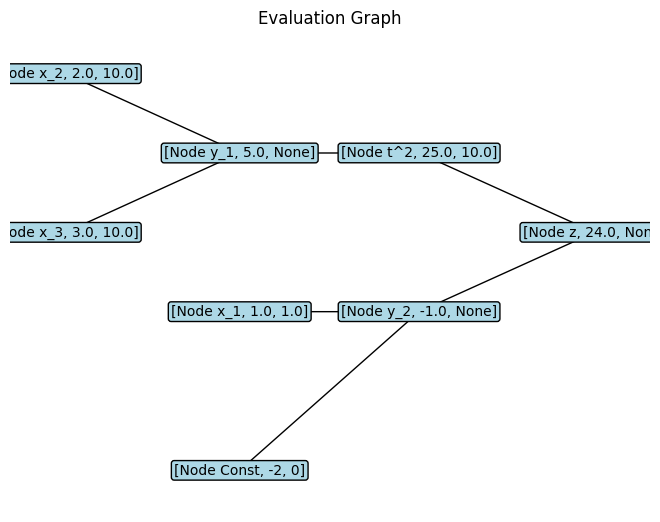

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

class EvalGraph:

    def __init__(self, f):
        self.foo = f
        self.G = None
    
    def build_graph(self):
        # add nodes -- depth first
        self.G = nx.DiGraph()
        pending_nodes = [self.foo]
        processed_nodes = {}

        while len(pending_nodes) > 0:
            x = pending_nodes.pop()
            if x in processed_nodes:
                continue
            id = len(processed_nodes)
            self.G.add_node(id, label=str(x))
            processed_nodes[x] = id
            for child in x.children:
                pending_nodes.append(child)
        
        for x, id in processed_nodes.items():
            for y in x.children:
                self.G.add_edge(processed_nodes[y], id)

    def draw(self):
        pos = nx.nx_agraph.graphviz_layout(self.G, prog='dot', args='-Grankdir=LR')
        nx.draw(self.G, pos, with_labels=False, arrows=True, node_size=0, node_color='lightblue')

        labels = nx.get_node_attributes(self.G, 'label')
        nx.draw_networkx_labels(
            self.G, pos, labels=labels, font_size=10, font_color='black',
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.2')
        )        
    
        plt.title("Evaluation Graph")
        plt.gca().invert_yaxis()
        plt.show()


eval_graph = EvalGraph(z)
eval_graph.build_graph()
eval_graph.draw()

# Tarea 1

Construya clases que compatibles siguiendo el esquema anterior para las funciones:

1. Multiply( [a_1, a_2, ..., a_n]): $a_1 \, a_2, \, a_3 \cdots a_n$
2. Pow($x$, $\alpha$): $x^{\alpha}$
3. Division(a, b): $\frac{a}{b}$
4. Exp(x): $e^x$

Para cada caso debe garantizar los siguientes:
1. El pass forward debe ser el correcto.
2. El backward debe propagar a los nodos necesarios.
3. Debe llenar la lista de childrens para poder dibujar el grafo de evaluación.

In [7]:
class Multiply(Node):
    def __init__(self, factor_list, name='*'):
        super().__init__(name)
        self.factors = factor_list
        self.children = factor_list

    def forward(self):
        self.value = 1.0
        for factor in self.factors:
            self.value *= factor.forward()
        return self.value

    def backward(self, upstream_gradient):
        for i, factor in enumerate(self.factors):
            grad = 1.0
            for j, f in enumerate(self.factors):
                if j != i:
                    grad *= f.value
            factor.backward(upstream_gradient * grad)

class Pow(Node):
    def __init__(self, var, exponent, name='Pow'):
        super().__init__(name)
        self.var = var
        self.exponent = exponent
        self.children = [var]

    def forward(self):
        self.value = self.var.forward() ** self.exponent
        return self.value

    def backward(self, upstream_gradient):
        grad = self.exponent * (self.var.value ** (self.exponent - 1))
        self.var.backward(upstream_gradient * grad)

class Division(Node):
    def __init__(self, a, b, name='/'):
        super().__init__(name)
        self.a = a
        self.b = b
        self.children = [a, b]

    def forward(self):
        self.value = self.a.forward() / self.b.forward()
        return self.value

    def backward(self, upstream_gradient):
        a_val = self.a.value
        b_val = self.b.value
        self.a.backward(upstream_gradient * (1 / b_val))
        self.b.backward(upstream_gradient * (-a_val / (b_val ** 2)))

class Exp(Node):
    def __init__(self, var, name='Exp'):
        super().__init__(name)
        self.var = var
        self.children = [var]

    def forward(self):
        self.value = np.exp(self.var.forward())
        return self.value

    def backward(self, upstream_gradient):
        self.var.backward(upstream_gradient * self.value)

# Tarea 2
Considere la función:
$$ z = f(x_1, x_2, x_3, x_4) = \left(1 - x_4 + x_4^{1/3} \right) \, \left(\frac{e^{-0.001 \, x_1^2\, x_2^3}}{\sqrt{1 + x_2^2 + x_3^2}}\right)$$

- Construya su grafo de evaluación usando las clases construidas anteriormente.
- Evalue la función para $x_1 = 1.0, x_2 = 2.0, x_3 = 3.0, x_4 = 4.1$.
- Calcule el gradiente de la función en el punto anterior.
- Dibuje el grafo de evaluación.


Valor de z: -0.39755947787329293
Gradientes:
dz/dx1 = 0.006360951645972686
dz/dx2 = 0.06156492485923565
dz/dx3 = 0.0851913166871342
dz/dx4 = -0.2306317844206126


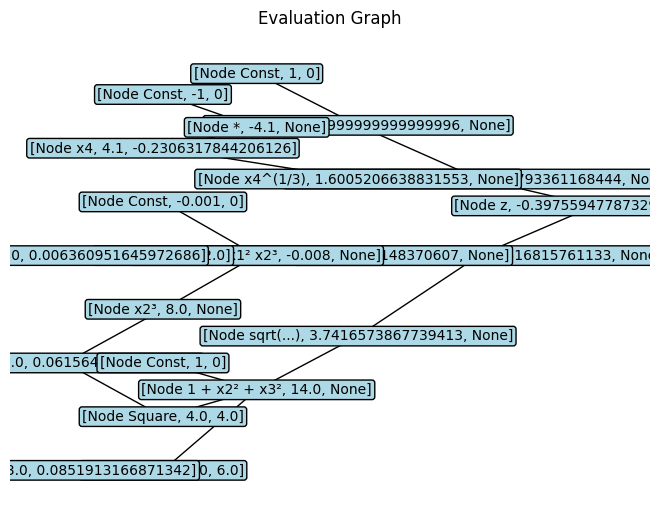

In [8]:
x1 = Variable(1.0, name='x1')
x2 = Variable(2.0, name='x2')
x3 = Variable(3.0, name='x3')
x4 = Variable(4.1, name='x4')

# U = (1 - x4 + x4^(1/3))
term1_a = Add([Constant(1), Multiply([Constant(-1), x4])], name='1 - x4')
term1_b = Pow(x4, 1/3, name='x4^(1/3)')
term1 = Add([term1_a, term1_b], name='1 - x4 + x4^(1/3)')

# V = (e^(-0.001 x1² x2³) / sqrt(1 + x2² + x3²))
x1_sq = Square(x1, name='x1²')
x2_cu = Pow(x2, 3, name='x2³')
product = Multiply([Constant(-0.001), x1_sq, x2_cu], name='-0.001 x1² x2³')
exp_term = Exp(product, name='e^(...)')

denom_a = Add([Constant(1), Square(x2), Square(x3)], name='1 + x2² + x3²')
denom = Pow(denom_a, 0.5, name='sqrt(...)')
term2 = Division(exp_term, denom, name='exp(...)/sqrt(...)')

# z = u * v
z = Multiply([term1, term2], name='z')

# Forward pass
z_value = z.forward()
print(f"Valor de z: {z_value}")

# Backward pass
z.backward(1.0)

print(f"Gradientes:")
print(f"dz/dx1 = {x1.gradient}")
print(f"dz/dx2 = {x2.gradient}")
print(f"dz/dx3 = {x3.gradient}")
print(f"dz/dx4 = {x4.gradient}")

eval_graph = EvalGraph(z)
eval_graph.build_graph()
eval_graph.draw()


---